In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_experiment"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(5) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,None,None,None,None,None,None,Female,0,No,No,No,0
1,21,8779-QRDMV,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65,DSL,No,No,Yes,No,No,Yes,Male,1,No,No,None,1
2,22,1680-VDCWW,2019-02-01,NaT,One year,No,Bank transfer (automatic),19.80,202.25,None,None,None,None,None,None,None,Male,0,Yes,No,No,0
3,23,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,None,None,None,None,None,None,None,Male,0,No,No,No,1
4,24,3638-WEABW,2015-04-01,NaT,Two year,Yes,Credit card (automatic),59.90,3505.10,DSL,No,Yes,No,Yes,No,No,Female,0,Yes,No,Yes,0


In [9]:
df['customer_id'].nunique()

7043

In [11]:
df['type'].nunique()

3

/tmp/ipykernel_92474/668383239.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0], hue=x, palette=sns.color_palette())
/tmp/ipykernel_92474/668383239.py:17: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0], hue=x, palette=sns.color_palette())
/tmp/ipykernel_92474/668383239.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_92474/668383239.py:26: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1], hue=x, palette=sns.color_palette())
/tmp/ipykernel_92474/668383239.py:33: UserWarning: The palette list has more values (10) than ne

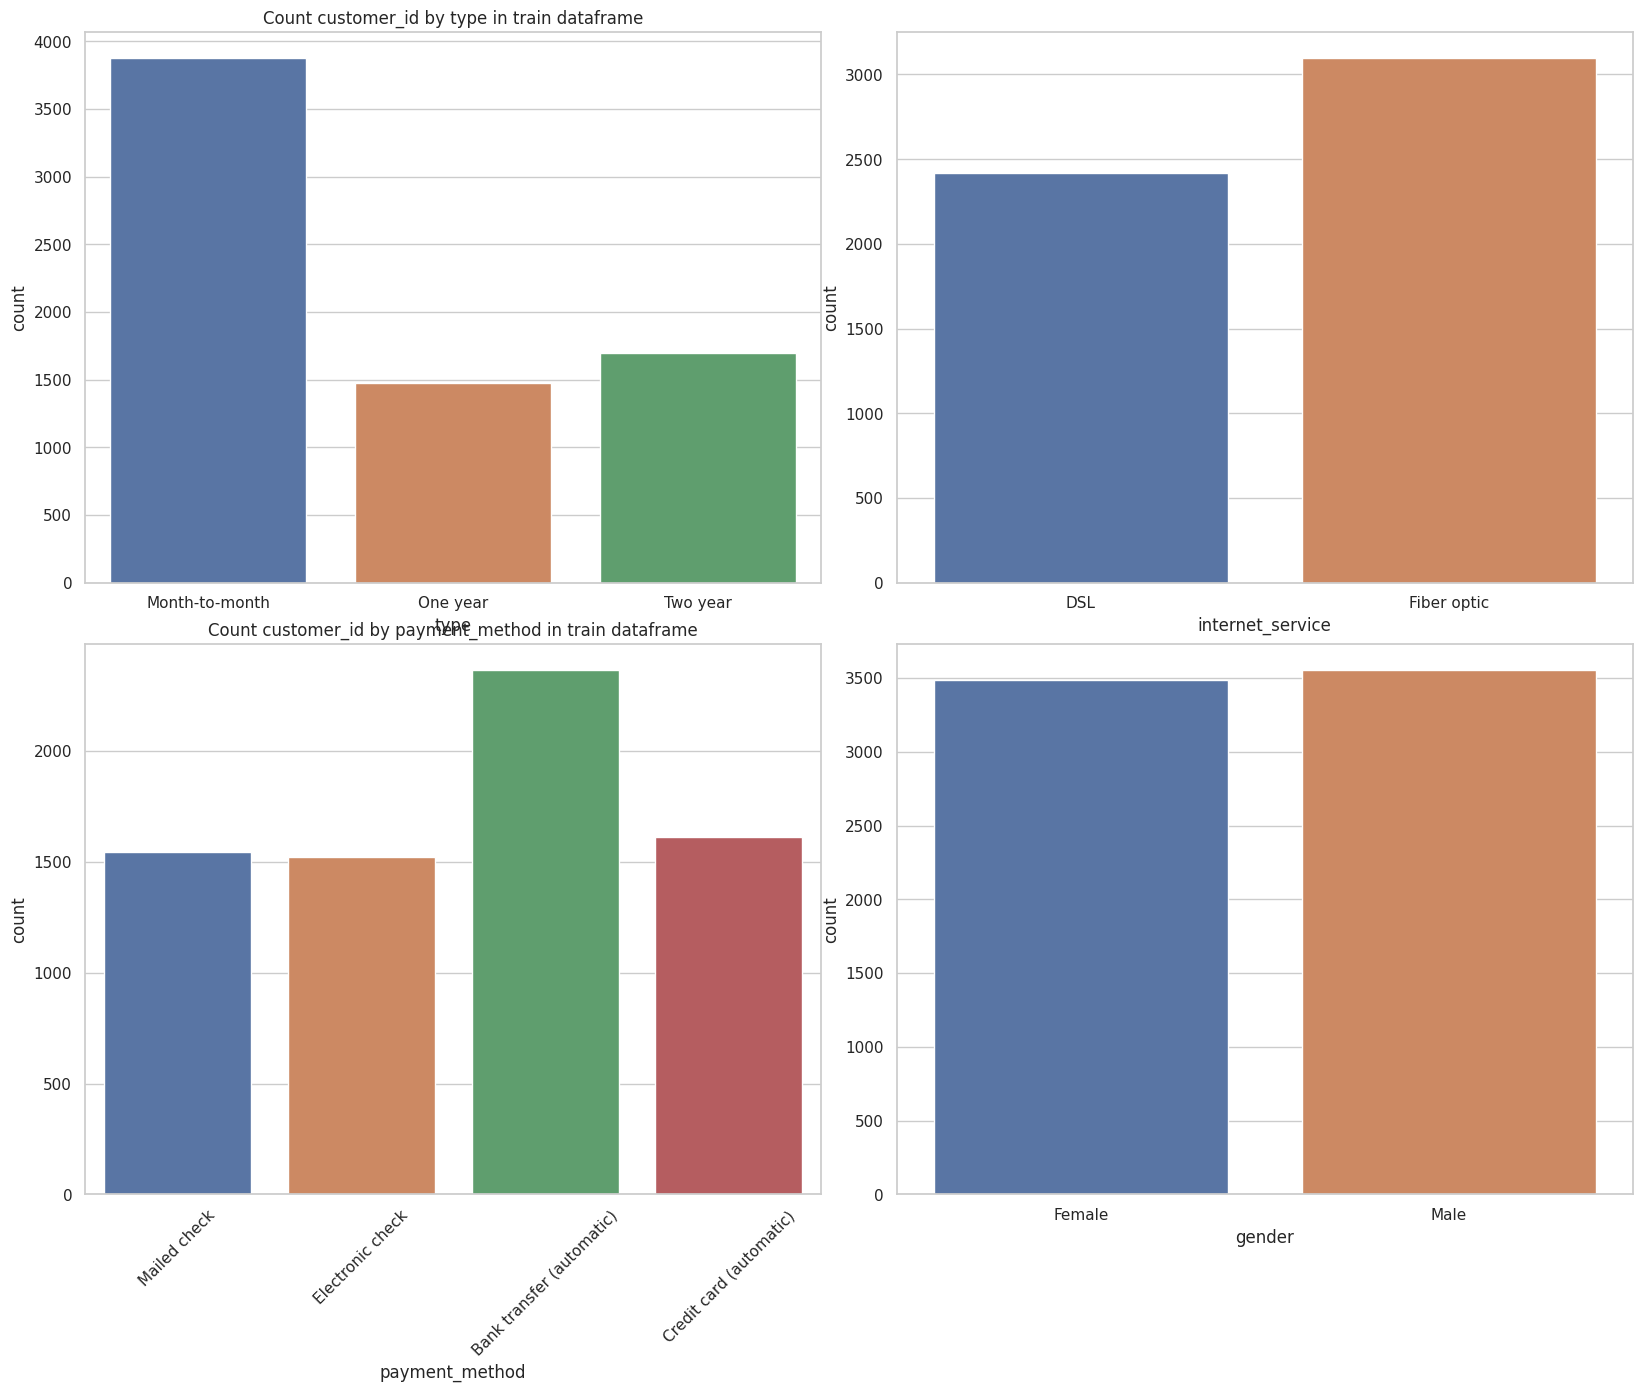

In [112]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0], hue=x, palette=sns.color_palette())
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0], hue=x, palette=sns.color_palette())

axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1], hue=x, palette=sns.color_palette())


x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1], hue=x, palette=sns.color_palette())

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [106]:
agg_df = pd.DataFrame(df.groupby(x).agg({x: stat[0]})).rename(columns={x: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])

<Axes: xlabel='type', ylabel='count'>

In [50]:
agg_df = df.groupby(x).agg({ x: stat })
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
#agg_df

ValueError: Could not interpret value `count` for `y`. An entry with this name does not appear in `data`.